In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from TDA_Segmentation import *
from sklearn.manifold import TSNE
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
import json

## Saving dataset specific information as JSON files

In [30]:
os.listdir('../Dataset- PAMAP Motion/PAMAP2_Dataset/Protocol/')

['subject101.dat',
 'subject102.dat',
 'subject103.dat',
 'subject104.dat',
 'subject105.dat',
 'subject106.dat',
 'subject107.dat',
 'subject108.dat',
 'subject109.dat']

In [5]:
dataset_info = dict()
dataset_info['col_name_map'] = {0: 'timestamp (s)', 1: 'activityID', 2: 'heart rate (bpm)', 4: 'hand_acc1', 5: 'hand_acc2', 6: 'hand_acc3',
                                21: 'chest_acc1', 22: 'chest_acc2', 23: 'chest_acc3', 38: 'ankle_acc1', 39: 'ankle_acc2', 40: 'ankle_acc3'}

dataset_info['activities_to_use'] = ['walking', 'running', 'cycling', 'nordic walking', 'ascending stairs', 'descending stairs']

In [3]:
activity_code_map = {0: 'other (transient activities)', 
                      1: 'lying',
                      2: 'sitting',
                      3: 'standing',
                      4: 'walking',
                      5: 'running',
                      6: 'cycling',
                      7: 'Nordic walking',
                      9: 'watching TV',
                      10: 'computer work',
                      11: 'car driving',
                      12: 'ascending stairs',
                      13: 'descending stairs',
                      16: 'vacuum cleaning',
                      17: 'ironing',
                      18: 'folding laundry',
                      19: 'house cleaning',
                      20: 'playing soccer',
                      24: 'rope jumping'}

dataset_info['activity_code_map'] = activity_code_map
dataset_info['cols_to_use'] = ['ankle_acc1', 'ankle_acc2', 'ankle_acc3']

## Finding the minimum stable window length above which the topological properties converge

In [ ]:
def get_activity_index_pairs(df_data, activity_list, activity_id_col, activity_code_reverse_map):
    separated_seg_data = separate_into_known_segments(df_data, activity_id_col)
    activity_id_list = [activity_code_reverse_map[activity_name_] for activity_name_ in activity_list]
    required_seg_data = [seg_pair for seg_pair in separated_seg_data if (int(seg_pair[0]) in activity_id_list)]
    return required_seg_data
    

In [7]:
col_name_map = {0: 'timestamp (s)', 1: 'activityID', 2: 'heart rate (bpm)', 4: 'hand_acc1', 5: 'hand_acc2', 6: 'hand_acc3',
                21: 'chest_acc1', 22: 'chest_acc2', 23: 'chest_acc3', 38: 'ankle_acc1', 39: 'ankle_acc2', 40: 'ankle_acc3'}

In [8]:
file_path = path = '../Dataset- PAMAP Motion/PAMAP2_Dataset/Protocol/subject102.dat'
arr = np.loadtxt(file_path)
df_timeseries = pd.DataFrame.from_dict({col_name_map[col_num]: arr[:, col_num] for col_num in col_name_map})
df_timeseries

,timestamp (s),activityID,heart rate (bpm),hand_acc1,hand_acc2,hand_acc3,chest_acc1,chest_acc2,chest_acc3,ankle_acc1,ankle_acc2,ankle_acc3
0,5.64,0.0,NaN,2.791430,7.553890,-7.06374,1.94739,9.59644,-3.12873,9.84408,-0.808951,-1.64674
1,5.65,0.0,NaN,2.860860,7.438140,-7.21626,1.75120,9.63340,-3.32601,9.83968,-0.807666,-1.80115
2,5.66,0.0,100.0,2.809970,7.094300,-7.52376,1.67059,9.70790,-3.48260,9.69127,-0.769071,-1.76432
3,5.67,0.0,NaN,2.771380,6.980770,-7.52396,1.66925,9.63234,-3.52110,9.80276,-0.921656,-1.76223
4,5.68,0.0,NaN,2.767100,7.131190,-7.67848,1.58969,9.66945,-3.63882,9.68318,-0.842759,-2.03407
...,...,...,...,...,...,...,...,...,...,...,...,...
446995,4475.59,0.0,NaN,-0.040828,-0.050765,9.77696,-1.44880,3.46617,-9.21080,-3.30042,-2.329950,8.72427
446996,4475.60,0.0,NaN,-0.004109,-0.013453,9.73890,-1.48682,3.50394,-9.21161,-3.31142,-2.326740,8.33824
446997,4475.61,0.0,NaN,-0.073003,-0.011192,9.93029,-1.44840,3.61679,-9.21128,-3.37987,-2.366160,8.56932
446998,4475.62,0.0,NaN,0.189650,0.099912,9.85688,-1.45079,3.57861,-9.28864,-3.30702,-2.328020,8.49265


In [6]:
# Printing the break points
break_pts = [0] + [ind for ind in range(1, len(df_timeseries)) if (df_timeseries.iloc[ind, 1] 
                   != df_timeseries.iloc[ind-1, 1])] + [len(df_timeseries)]
print(break_pts)

[0, 4956, 28386, 34652, 56997, 59024, 84600, 90244, 119124, 127214, 147897, 172853, 181578, 191561, 199352, 242347, 250964, 258386, 277508, 310041, 322406, 352145, 358225, 383333, 390980, 400218, 410743, 424005, 447000]


In [9]:
# Important activities to use in segmentation data
activity_index_pairs = [('walking', (277508, 310041)), ('running', (390980, 400218)), ('cycling', (358225, 383333)), 
                        ('nordic walking', (322406, 352145)), ('ascending stairs', (172853, 181578)), 
                        ('descending stairs', (191561, 199352))]

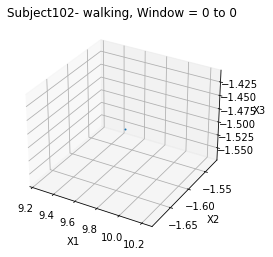

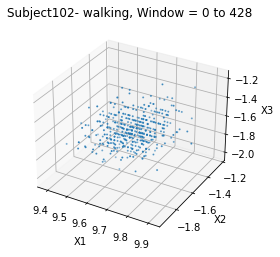

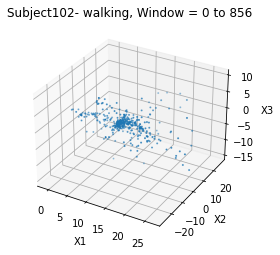

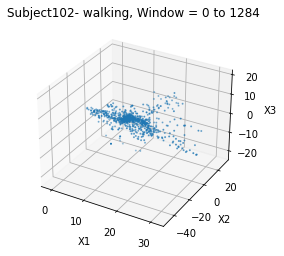

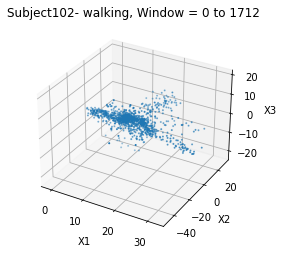

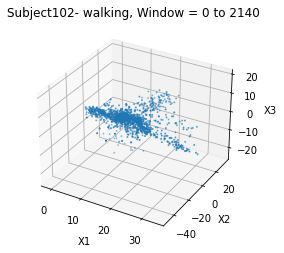

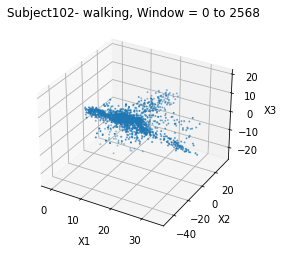

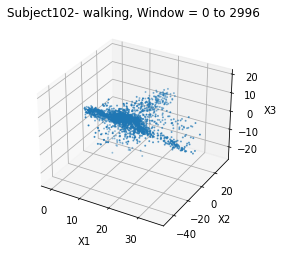

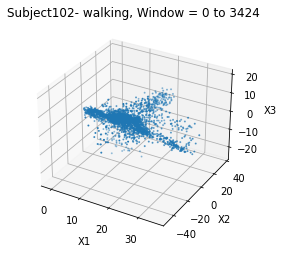

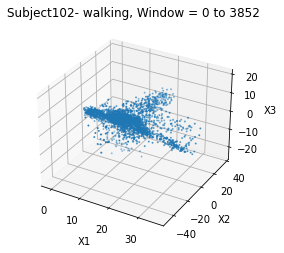

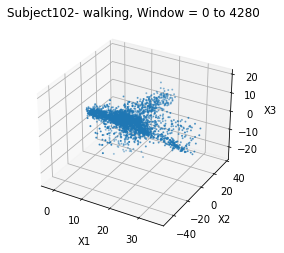

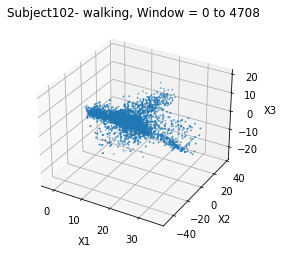

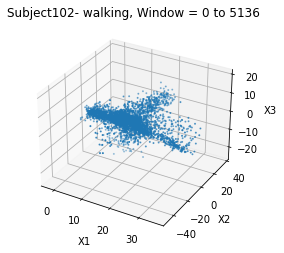

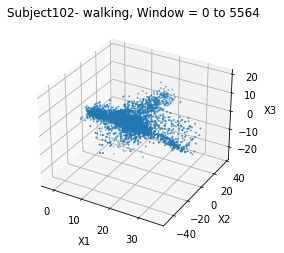

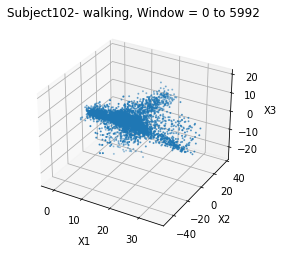

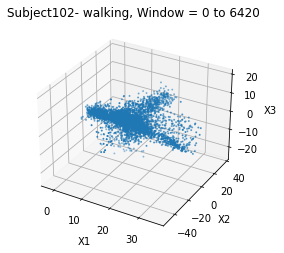

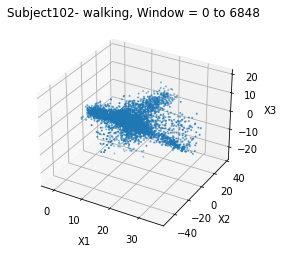

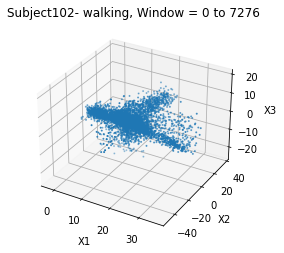

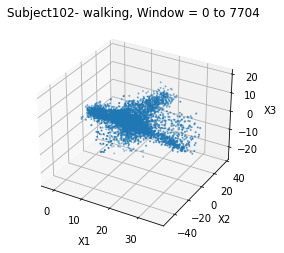

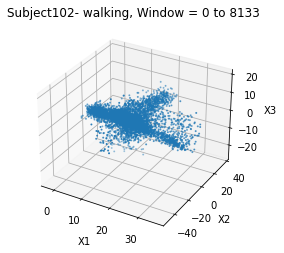

In [51]:
# Visualizing the point cloud embedding for increasing window sizes
num_steps = 20
for activity, index_pair in activity_index_pairs[0: 1]:
    N1, N2 = index_pair[0], index_pair[1]
    N2_vals = np.linspace(N1, int(N1 + (N2-N1)/4), num = num_steps, dtype = int)
    for ind, N2_val_ in enumerate(N2_vals):
        fig = plt.figure(figsize=(4, 4))
        ax = fig.add_subplot(111, projection = '3d')
        ax.scatter3D(df_timeseries.loc[N1: N2_val_, 'ankle_acc1'], df_timeseries.loc[N1: N2_val_,'ankle_acc2'], 
                     df_timeseries.loc[N1: N2_val_, 'ankle_acc3'], s = 1)
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('X3')
        ax.set_title('Subject102- {}, Window = {} to {}'.format(activity, 0, N2_val_-N1))
    #get_persistence_diagrams_multivariate(ts_arr_multivar, ax[1])

In [14]:
# Visualizing the persistence diagram space for increasing window sizes
persisDiagrams = []
num_steps = 20
for activity, index_pair in activity_index_pairs[0: 1]:
    N1, N2 = index_pair[0], index_pair[1]
    N2_vals = np.linspace(N1, int(N1 + (N2-N1)/4), num = num_steps, dtype = int)
    for ind, N2_val_ in enumerate(N2_vals[1:]):
        point_cloud_3d = np.array([df_timeseries.loc[N1: N2_val_, 'ankle_acc1'], 
                                   df_timeseries.loc[N1: N2_val_,'ankle_acc2'], 
                                   df_timeseries.loc[N1: N2_val_, 'ankle_acc3']]).T
        point_cloud_3d = point_cloud_3d[~np.isnan(point_cloud_3d).any(axis = 1), :]
        print(point_cloud_3d.shape)
        currPersisDiagram = get_persistence_diagrams_multivariate(point_cloud_3d, homology_dimensions = [1])
        persisDiagrams.append(currPersisDiagram)

print(len(persisDiagrams))

(429, 3)
(854, 3)
(1275, 3)
(1703, 3)
(2125, 3)
(2550, 3)
(2976, 3)
(3402, 3)
(3829, 3)
(4254, 3)
(4678, 3)
(5094, 3)
(5517, 3)
(5941, 3)
(6367, 3)
(6793, 3)
(7221, 3)
(7647, 3)
(8074, 3)
19


In [36]:
pairwise_dist = np.zeros((len(persisDiagrams), len(persisDiagrams)), dtype = float)
for ind1 in range(len(persisDiagrams)):
    #print(persisDiagrams[ind1].shape)
    for ind2 in range(len(persisDiagrams)):
        pairwise_dist[ind1, ind2] = Segmentation_Persistent_Homology('multivariate', 'sliced_wasserstein').\
                                    sliced_wasserstein_dist(persisDiagrams[ind1], persisDiagrams[ind2])
        
print(pairwise_dist)

[[0.         1.50984559 2.01441422 1.92559449 1.96288788 1.660738
  1.71596469 1.46265285 1.4529105  1.47486056 1.47535568 1.5323689
  1.46816672 1.37135317 1.36194028 1.25449365 1.29820235 1.31082964
  1.42795241]
 [1.50778371 0.         0.59877278 0.64909052 0.71221563 0.63968379
  0.61235732 0.59879699 0.60122932 0.6781049  0.65177242 0.65404428
  0.69920281 0.69793374 0.70844939 0.6892072  0.67320455 0.65748777
  0.65382597]
 [1.80428682 0.54984164 0.         0.23238857 0.28566831 0.30617221
  0.3433215  0.40294463 0.43294299 0.44054475 0.4689944  0.56446839
  0.59343577 0.55706474 0.58232656 0.60557586 0.64027878 0.59174782
  0.59355439]
 [1.80716011 0.64260832 0.21079996 0.         0.13093308 0.20436242
  0.21839332 0.31522598 0.37702383 0.35781742 0.3753745  0.43532134
  0.46435948 0.51765813 0.4439151  0.46961844 0.56756843 0.5368261
  0.59916872]
 [1.90545256 0.69668725 0.29702588 0.12093471 0.         0.18990473
  0.2163558  0.35950074 0.39986933 0.36908836 0.39099065 0.45021

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


(19, 2)


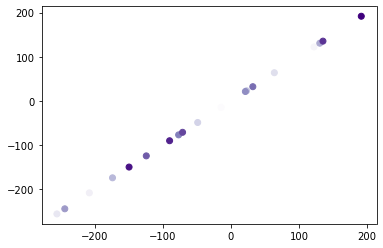

In [40]:
# TSNE Visualization (Not useful for finding the minimum window length)
tsne_obj = TSNE(metric = 'precomputed')
tsne_embedding = tsne_obj.fit_transform(pairwise_dist)
print(tsne_embedding.shape)
cm = plt.get_cmap('Purples')
plt.figure()
plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], c = cm(np.linspace(0, 1, num = len(persisDiagrams))))
plt.show()

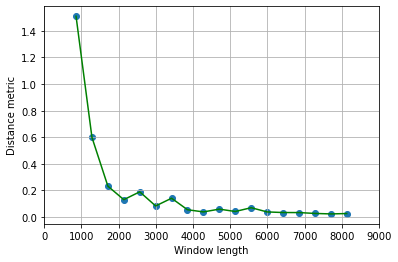

In [49]:
# Topological distance between consecutive extensions
consecutive_dists = [pairwise_dist[i, i+1] for i in range(len(persisDiagrams)-1)]
plt.figure()
plt.scatter(np.linspace(0, int((N2-N1)/4), num = num_steps, dtype = int)[2:], consecutive_dists)
plt.plot(np.linspace(0, int((N2-N1)/4), num = num_steps, dtype = int)[2:], consecutive_dists, c = 'g')
plt.xlim([0, 9000])
plt.xlabel('Window length')
plt.ylabel('Distance metric')
plt.grid()
plt.show()

In [12]:
np.linspace(0, 1000, num = 12, dtype = int)

array([   0,   90,  181,  272,  363,  454,  545,  636,  727,  818,  909,
       1000])

## Testing the segmentation algorithm

In [10]:
# Concatenate the selected four activities into a single time series, removing null values
har_ts_test = pd.concat([df_timeseries.iloc[ind_pair[1][0]: ind_pair[1][1]] for ind_pair in 
                         activity_index_pairs], ignore_index = True)

har_ts_test.dropna(axis = 0, how = 'any', subset = ['ankle_acc1', 'ankle_acc2', 'ankle_acc3'], inplace = True)
har_ts_test.reset_index(drop = True, inplace = True)
har_ts_test

,timestamp (s),activityID,heart rate (bpm),hand_acc1,hand_acc2,hand_acc3,chest_acc1,chest_acc2,chest_acc3,ankle_acc1,ankle_acc2,ankle_acc3
0,2780.72,4.0,NaN,-9.37273,2.94536,1.46774,2.137390,8.79671,-4.36176,9.73205,-1.60687,-1.48858
1,2780.73,4.0,NaN,-9.44162,2.94762,1.65914,2.100410,8.79709,-4.32371,9.72925,-1.72013,-1.56508
2,2780.74,4.0,NaN,-9.48289,3.02278,1.54281,1.991690,8.76109,-4.13196,9.65440,-1.71965,-1.56585
3,2780.75,4.0,NaN,-9.55900,2.94749,1.54192,1.990000,8.98649,-4.21016,9.65161,-1.83292,-1.64236
4,2780.76,4.0,NaN,-9.44831,2.94594,1.46661,2.103500,9.09884,-4.24719,9.50631,-1.83325,-1.48949
...,...,...,...,...,...,...,...,...,...,...,...,...
112059,1999.11,13.0,NaN,5.17913,7.39917,7.36682,1.279800,9.51875,-3.79883,9.72644,-1.41509,-1.72136
112060,1999.12,13.0,NaN,5.71086,7.58512,7.41265,0.972396,9.44388,-3.88160,9.65469,-1.45355,-1.60609
112061,1999.13,13.0,NaN,6.12226,7.92168,7.22524,1.160280,9.29215,-3.95514,9.57444,-1.64164,-1.76010
112062,1999.14,13.0,NaN,6.30718,8.29794,7.03430,1.170970,9.44510,-3.60696,9.72954,-1.45403,-1.60532


In [31]:
def separate_into_known_segments(df_data, label_column):
    N_df = len(df_data)
    start_ind_, curr_label_ = 0, df_data.loc[0, label_column]
    separated_segs = []
    for ind_ in range(N_df):
        if df_data.loc[ind_, label_column] != curr_label_:
            separated_segs.append((curr_label_, (start_ind_, ind_)))
            curr_label_ = df_data.loc[ind_, label_column]
            start_ind_ = ind_
    
    separated_segs.append((curr_label_, (start_ind_, N_df)))
    return separated_segs
            

### Observation- Perisistent homology of large point clouds (size > 10k) causes a Memory Error
### So, merging the windows and computing the similarity between larger windows may not be a good idea.
### Instead, clustering the representations of smaller windows may be a better approach.

In [61]:
seg_obj = Segmentation_Persistent_Homology('multivariate', 'sliced_wasserstein')
seg_data = har_ts_test[['ankle_acc1', 'ankle_acc2', 'ankle_acc3']].values
seg_intervals = seg_obj.get_segmentation(seg_data, 1200)

[[0, 1200], [1200, 2400], [2400, 3600], [3600, 4800], [4800, 6000], [6000, 7200], [7200, 8400], [8400, 9600], [9600, 10800], [10800, 12000], [12000, 13200], [13200, 14400], [14400, 15600], [15600, 16800], [16800, 18000], [18000, 19200], [19200, 20400], [20400, 21600], [21600, 22800], [22800, 24000], [24000, 25200], [25200, 26400], [26400, 27600], [27600, 28800], [28800, 30000], [30000, 31200], [31200, 32400], [32400, 33600], [33600, 34800], [34800, 36000], [36000, 37200], [37200, 38400], [38400, 39600], [39600, 40800], [40800, 42000], [42000, 43200], [43200, 44400], [44400, 45600], [45600, 46800], [46800, 48000], [48000, 49200], [49200, 50400], [50400, 51600], [51600, 52800], [52800, 54000], [54000, 55200], [55200, 56400], [56400, 57600], [57600, 58800], [58800, 60000], [60000, 61200], [61200, 62400], [62400, 63600], [63600, 64800], [64800, 66000], [66000, 67200], [67200, 68400], [68400, 69600], [69600, 70800], [70800, 72000], [72000, 73200], [73200, 74400], [74400, 75600], [75600, 768

Indices = 0 and 1, distance = 0.1213381850015363
Indices = 2 and 3, distance = 0.15526319658007134
Indices = 4 and 5, distance = 0.0937650975907946
Indices = 6 and 7, distance = 1.3743687925137515
Indices = 7 and 8, distance = 0.6940148357672231
Indices = 9 and 10, distance = 4.3984008806426855
Indices = 10 and 11, distance = 0.1722282703747187
Indices = 12 and 13, distance = 0.09170506926011522
Indices = 14 and 15, distance = 0.8039923754016571
Indices = 16 and 17, distance = 0.19041899646094587
Indices = 18 and 19, distance = 0.17581069937430788
Indices = 20 and 21, distance = 0.20972190737295276
Indices = 22 and 23, distance = 2.2051943801533445
Indices = 23 and 24, distance = 1.9951580976306311
Indices = 24 and 25, distance = 1.6731052038525107
Indices = 25 and 26, distance = 1.3386167850513064
Indices = 26 and 27, distance = 1.5208017731852503
Indices = 27 and 28, distance = 1.7536456054701564
Indices = 28 and 29, distance = 1.6410133270764065
Indices = 29 and 30, distance = 0.491

MemoryError: bad allocation

In [65]:
# Getting the true segmentation intervals
break_pts_test = [0] + [ind for ind in range(1, len(har_ts_test)) if (har_ts_test.iloc[ind, 1] 
                   != har_ts_test.iloc[ind-1, 1])] + [len(har_ts_test)]
print(break_pts_test)

[0, 32291, 41457, 66053, 95559, 104280, 112064]


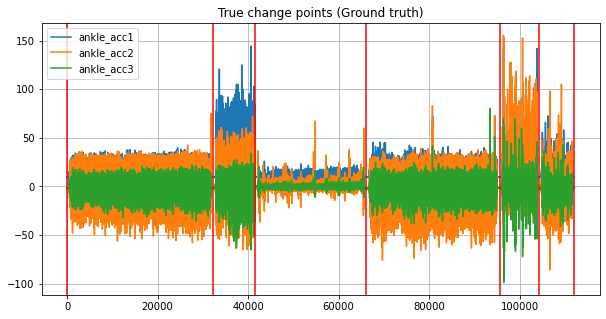

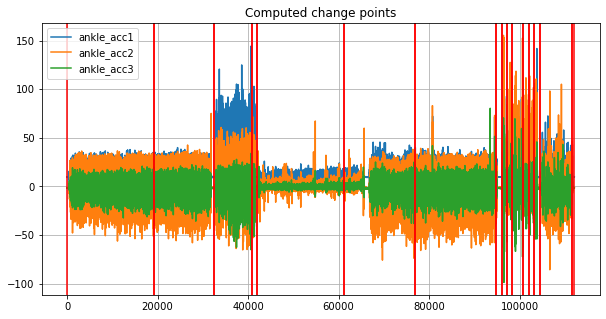

In [17]:
# Visualizing the segmentation results
break_pts_test = [0, 32291, 41457, 66053, 95559, 104280, 112064]
seg_intervals_partial_results = [[0, 19200], [19200, 32400], [32400, 40800], [40800, 42000], [42000, 61200], 
                                 [61200, 76800], [76800, 94800], [94800, 96000], [96000, 97200], [97200, 98400], 
                                 [98400, 100800], [100800, 102000], [102000, 103200], [103200, 104400], [104400, 111600], 
                                 [111600, 112064]]

# Plotting true break points
plt.figure(figsize = (10,5))
plt.plot(har_ts_test['ankle_acc1'], label = 'ankle_acc1')
plt.plot(har_ts_test['ankle_acc2'], label = 'ankle_acc2')
plt.plot(har_ts_test['ankle_acc3'], label = 'ankle_acc3')

for break_pt_ in break_pts_test:
    plt.axvline(break_pt_, c = 'r')
plt.legend()
plt.grid()
plt.title('True change points (Ground truth)')
plt.show()

# Plotting computed break points
plt.figure(figsize = (10, 5))
plt.plot(har_ts_test['ankle_acc1'], label = 'ankle_acc1')
plt.plot(har_ts_test['ankle_acc2'], label = 'ankle_acc2')
plt.plot(har_ts_test['ankle_acc3'], label = 'ankle_acc3')

for interval_ in seg_intervals_partial_results:
    plt.axvline(interval_[0], c = 'r')
    plt.axvline(interval_[1], c = 'r')
plt.legend()
plt.grid()
plt.title('Computed change points')
plt.show()

# We observe that there is some match (at the least) between the true and computed change points

## Alternative Methodology- Plotting clusters of embeddings

In [9]:
activity_segs = separate_into_known_segments(har_ts_test, 'activityID')
activity_segs

[(4.0, (0, 32291)),
 (5.0, (32291, 41457)),
 (6.0, (41457, 66053)),
 (7.0, (66053, 95559)),
 (12.0, (95559, 104280)),
 (13.0, (104280, 112064))]

In [10]:
cols_to_use = ['ankle_acc1', 'ankle_acc2', 'ankle_acc3']

In [11]:
# Sampling from every activity
def get_samples_from_every_segment(window_len, num_intervals, activity_index_pairs_):
    activity_sampled_intervals = []
    for activity_name_, activity_interval_ in activity_index_pairs_:
        sampled_intervals_start = np.linspace(activity_interval_[0], activity_interval_[1]-window_len, num_intervals, dtype = int)
        sampled_intervals_end = np.linspace(activity_interval_[0]+window_len, activity_interval_[1], num_intervals, dtype = int)
        sampled_intervals = [(start_, end_) for start_, end_ in zip(sampled_intervals_start, sampled_intervals_end)]
        activity_sampled_intervals.append((activity_name_, sampled_intervals))

    return activity_sampled_intervals

In [12]:
sampled_intervals = get_samples_from_every_segment(1200, 100, activity_segs)

In [13]:
sampled_intervals

[(4.0,
  [(0, 1200),
   (314, 1514),
   (628, 1828),
   (942, 2142),
   (1256, 2456),
   (1570, 2770),
   (1884, 3084),
   (2198, 3398),
   (2512, 3712),
   (2826, 4026),
   (3140, 4340),
   (3454, 4654),
   (3768, 4968),
   (4082, 5282),
   (4396, 5596),
   (4710, 5910),
   (5024, 6224),
   (5338, 6538),
   (5652, 6852),
   (5966, 7166),
   (6281, 7481),
   (6595, 7795),
   (6909, 8109),
   (7223, 8423),
   (7537, 8737),
   (7851, 9051),
   (8165, 9365),
   (8479, 9679),
   (8793, 9993),
   (9107, 10307),
   (9421, 10621),
   (9735, 10935),
   (10049, 11249),
   (10363, 11563),
   (10677, 11877),
   (10991, 12191),
   (11305, 12505),
   (11619, 12819),
   (11933, 13133),
   (12247, 13447),
   (12562, 13762),
   (12876, 14076),
   (13190, 14390),
   (13504, 14704),
   (13818, 15018),
   (14132, 15332),
   (14446, 15646),
   (14760, 15960),
   (15074, 16274),
   (15388, 16588),
   (15702, 16902),
   (16016, 17216),
   (16330, 17530),
   (16644, 17844),
   (16958, 18158),
   (17272, 1847

In [52]:
# Computing persistence diagrams for all intervals of each activity
persisDiagramsSimulations = []
for activity_name_, intervals_ls_ in tqdm(sampled_intervals):
    persisDiagramsAct = []
    for curr_interval_ in tqdm(intervals_ls_):
        interval_data_arr = har_ts_test.loc[curr_interval_[0]: curr_interval_[1], cols_to_use].values
        persisDiagramsAct.append(get_persistence_diagrams_multivariate(interval_data_arr)[0])
        
    persisDiagramsSimulations.append((activity_name_, persisDiagramsAct))

print(len(persisDiagramsSimulations))

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

6


In [55]:
len(persisDiagramsSimulations[0][1])

100

In [16]:
arrtemp = np.array([[1.0, 2.3], [8.3, 2.1], [3.4, 1.9]], dtype = float)
np.savetxt("data3.csv", arrtemp, delimiter = ",")

In [61]:
num_activities, windows_per_activity = 6, 100
def parallelize_sliced_wass_distance(ind1, ind2):
    diagram1 = persisDiagramsSimulations[int(ind1/windows_per_activity)][1][ind1%windows_per_activity]
    diagram2 = persisDiagramsSimulations[int(ind2/windows_per_activity)][1][ind2%windows_per_activity]
    return sliced_wasserstein_dist(diagram1, diagram2)

In [ ]:
# Finding the pairwise dissimilarity matrix
num_activities, windows_per_activity = 6, 100
dissimilarity_matrix = np.zeros((num_activities*windows_per_activity, num_activities*windows_per_activity), dtype = float)
for ind1 in tqdm(range(dissimilarity_matrix.shape[0])):
    diagram1 = persisDiagramsSimulations[int(ind1/windows_per_activity)][1][ind1%windows_per_activity]
    for ind2 in tqdm(range(dissimilarity_matrix.shape[0])):
        diagram2 = persisDiagramsSimulations[int(ind2/windows_per_activity)][1][ind2%windows_per_activity]
        dissimilarity_matrix[ind1, ind2] = sliced_wasserstein_dist(diagram1, diagram2)
        
print(dissimilarity_matrix.shape)

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


(94, 2)


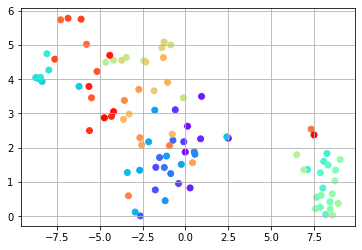

In [88]:
# Plotting TSNE visualizations
tsne_obj = TSNE(n_components = 2, metric = 'precomputed', random_state = 10)
tsne_embedding = tsne_obj.fit_transform(dissimilarity_matrix)
print(tsne_embedding.shape)
cm = plt.get_cmap('rainbow')
plt.figure()
plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], c = cm(np.linspace(0, 1, num = tsne_embedding.shape[0])))
plt.grid()
plt.show()

In [81]:
print(dissimilarity_matrix[0])

[0.         0.71516424 0.68796865 0.9107827  0.83863893 0.55315156
 0.83191657 0.75678001 0.86683955 0.93657763 1.02402999 1.19874416
 0.75632419 0.79144563 0.89432561 0.8855143  0.70006892 0.66165021
 0.91811595 0.90762989 0.84825004 0.78418422 0.989668   0.84074152
 1.20442064 1.15651459 0.44596269 1.51151971 2.72859047 3.1440238
 2.95579323 3.37893075 2.85315743 2.8876001  3.16301714 0.75457953
 1.31339524 1.35662308 1.15340616 1.26591901 0.98718257 1.20640416
 1.19998511 1.17725703 1.25253238 1.03272223 1.3332579  1.20235119
 1.20321974 1.32102941 1.13628422 1.23488719 1.1375595  1.08926252
 0.82396449 0.69947233 0.9985266  1.20360501 1.20973307 1.09160733
 0.76648891 0.83240616 1.09211227 0.91378375 1.13293627 0.9871234
 0.84866207 0.99869557 0.79271094 0.93533789 0.85247088 0.85798712
 0.97510826 0.77098192 1.12358985 0.98418904 1.06230729 1.17693861
 0.90416799 1.11776853 1.45421326 3.06652071 1.25604508 1.16600296
 3.03129544 2.39951636 2.07110151 0.99404948 0.99554735 1.422546

## TSNE Visualization from Saved Data

### Observation- Dissimilarity based on persistence diagrams can separate the activities / segments satisfactorily

In [26]:
def plot_tsne_visualization_segments(similarity_file_path, segment_list_path, plot_title, num_segs_per_interval = 100):
    # Loading distance matrix and getting TSNE embeddings
    dissimilarity_matrix = np.loadtxt(similarity_file_path, delimiter = ',')
    tsne_obj = TSNE(n_components = 2, metric = 'precomputed', random_state = 100)
    tsne_embedding = tsne_obj.fit_transform(dissimilarity_matrix)
    # Loading and processing the sampled interval list
    with open(segment_list_path, 'r') as f:
        sampled_segments = json.loads(f.read())
    num_segs = dissimilarity_matrix.shape[0]
    segs_labels = [pair_[0] for ind_, pair_ in enumerate(sampled_segments) for segment_ in pair_[1]]
    segs_id_labels = np.zeros((len(segs_labels),), dtype = int)
    segs_id_unique_labels = []
    num_changes = int(len(segs_labels)/num_segs_per_interval)
    legend_labels = []
    for i in range(num_changes):
        segs_id_labels[i*num_segs_per_interval: (i+1)*num_segs_per_interval] = i
        segs_id_unique_labels.append(i)
        legend_labels.append('Segment {}- Activity {}'.format(i, segs_labels[i*num_segs_per_interval]))
    color_vals = (1.0/(np.max(segs_id_labels)-np.min(segs_id_labels)))*(segs_id_labels-np.min(segs_id_labels))
    # Generating plot with segment-wise colouring
    cm = plt.get_cmap('rainbow')
    plt.figure(figsize = (20, 12))
    for seg_id_, legend_label_ in zip(segs_id_unique_labels, legend_labels):
        seg_indices = (segs_id_labels == seg_id_)
        plt.scatter(tsne_embedding[seg_indices, 0], tsne_embedding[seg_indices, 1], c = cm(color_vals[seg_indices]),
                    label = legend_label_)
    plt.legend()
    plt.grid()
    plt.title(plot_title)
    plt.show()
    return

def plot_tsne_visualization_activities(similarity_file_path, segment_list_path, plot_title):
    # Loading distance matrix and getting TSNE embeddings
    dissimilarity_matrix = np.loadtxt(similarity_file_path, delimiter = ',')
    tsne_obj = TSNE(n_components = 2, metric = 'precomputed', random_state = 100)
    tsne_embedding = tsne_obj.fit_transform(dissimilarity_matrix)
    # Loading and processing the sampled interval list
    with open(segment_list_path, 'r') as f:
        sampled_segments = json.loads(f.read())
    num_segs = dissimilarity_matrix.shape[0]
    segs_labels = [pair_[0] for ind_, pair_ in enumerate(sampled_segments) for segment_ in pair_[1]]  
    activity_unique_labels = sorted(set(segs_labels))
    activity_label_ids = list(np.arange(len(activity_unique_labels)))
    activity_label_color_ids = (1.0/np.max(activity_label_ids)-np.min(activity_label_ids))*(activity_label_ids-np.min(activity_label_ids))

    # Generating plot with activity-wise colouring
    cm = plt.get_cmap('rainbow')
    plt.figure(figsize = (20, 12))
    for activity_id_, activity_color_id_ in zip(activity_unique_labels, activity_label_color_ids):
        activity_indices = (np.array(segs_labels) == activity_id_)
        plt.scatter(tsne_embedding[activity_indices, 0], tsne_embedding[activity_indices, 1], color = cm(activity_color_id_),
                    label = 'Activity {}'.format(activity_id_))
    plt.legend()
    plt.grid()
    plt.title(plot_title)
    plt.show()
    return

In [13]:
subject_ids = ['subject101',
                 'subject102',
                 'subject103',
                 'subject104',
                 'subject105',
                 'subject106',
                 'subject107',
                 'subject108']
similarity_data_path = './Persistence_Homology_Output/'

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


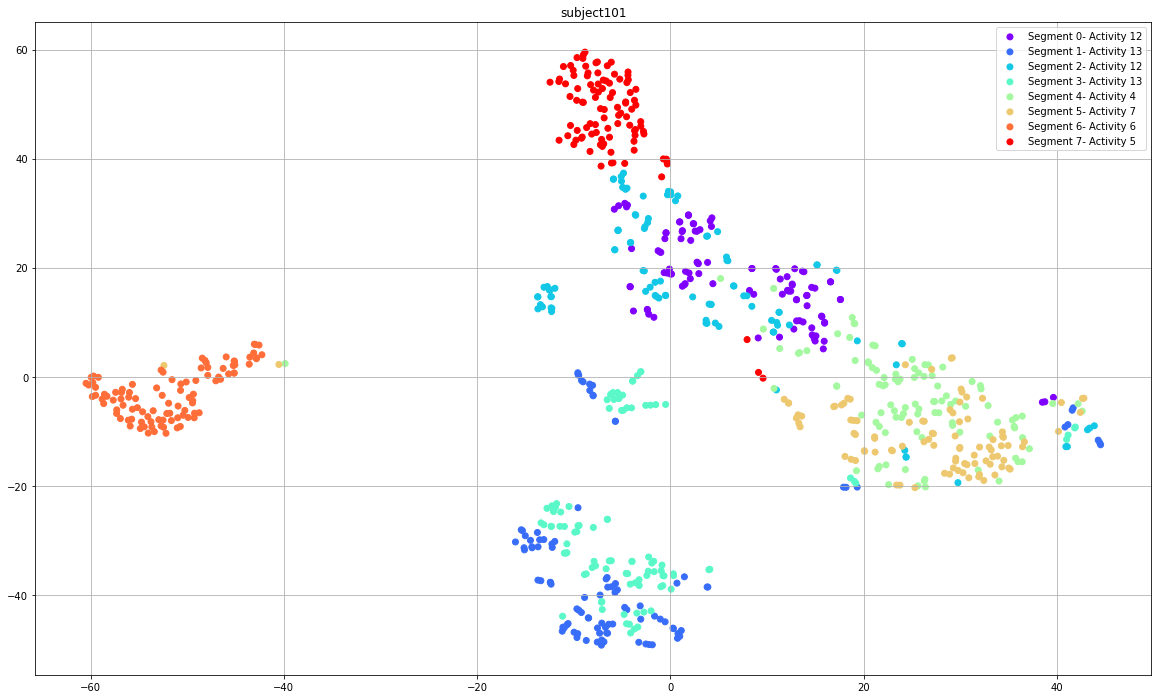

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


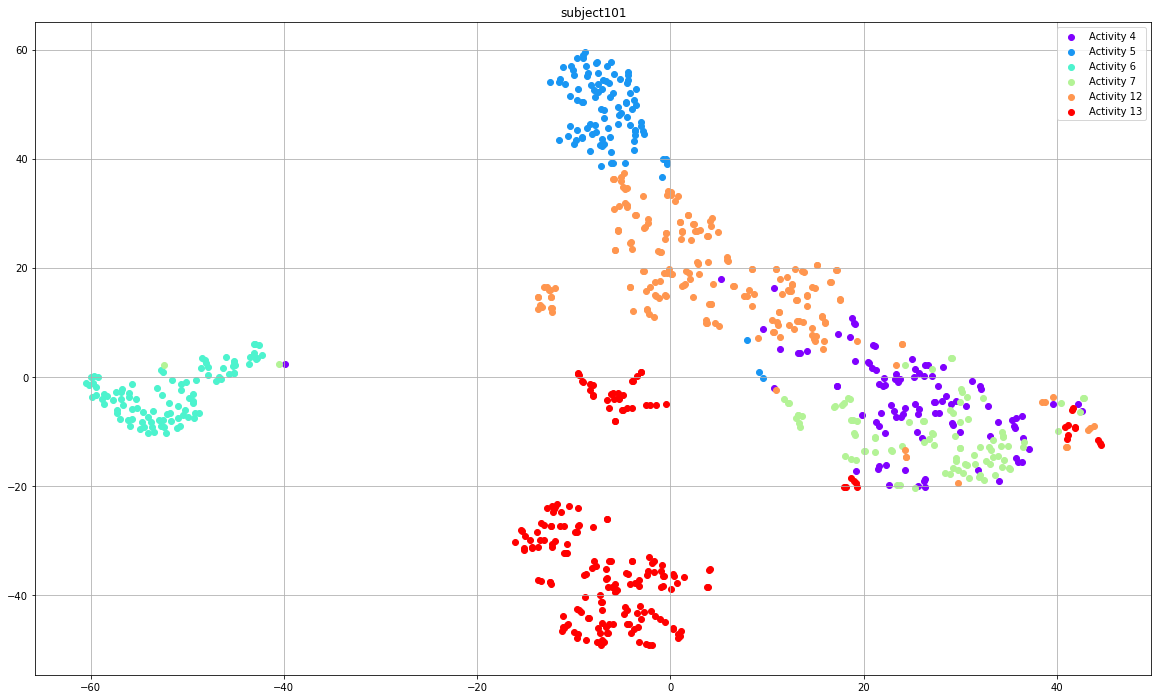

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


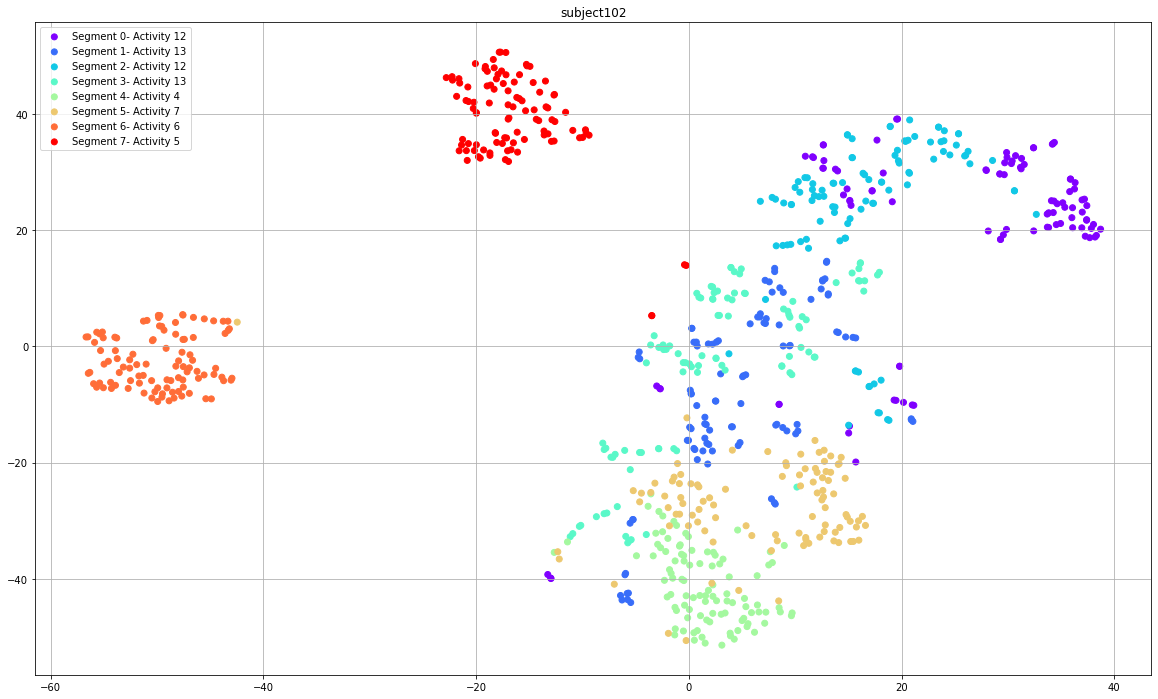

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


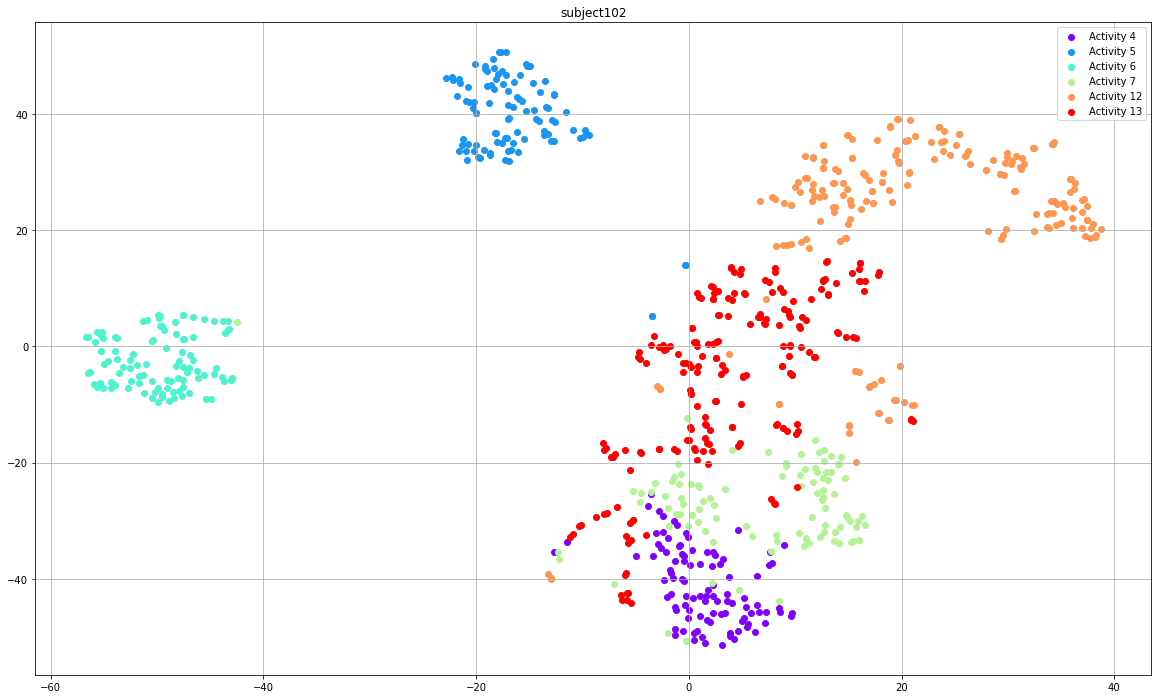

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


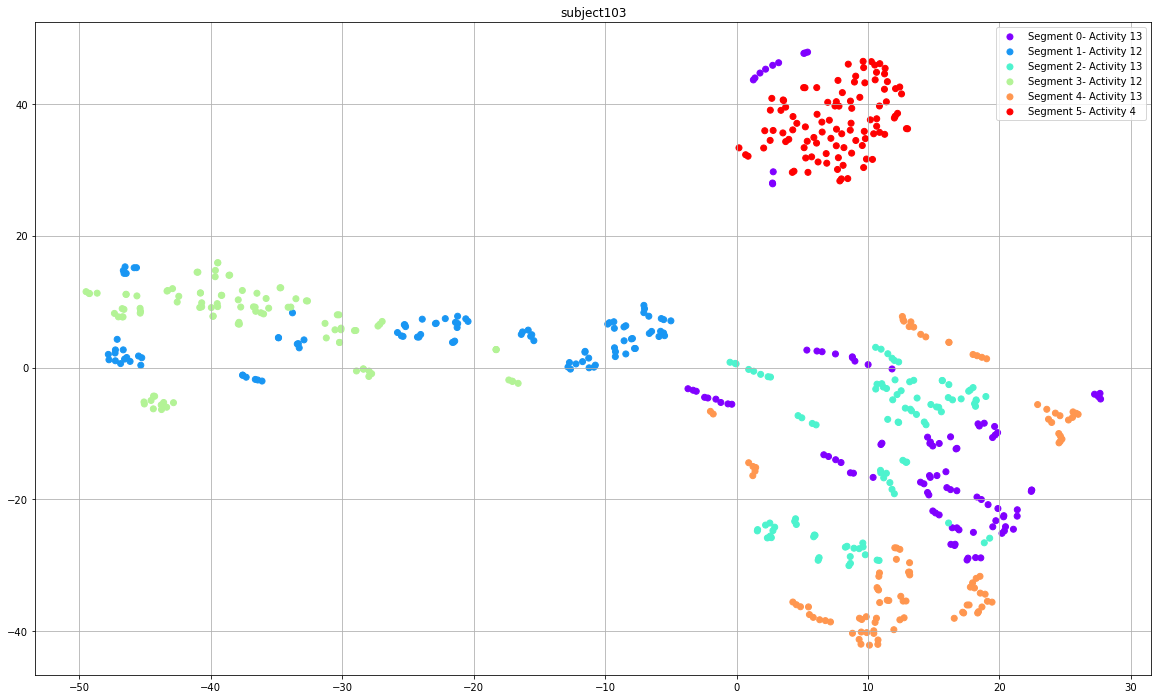

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


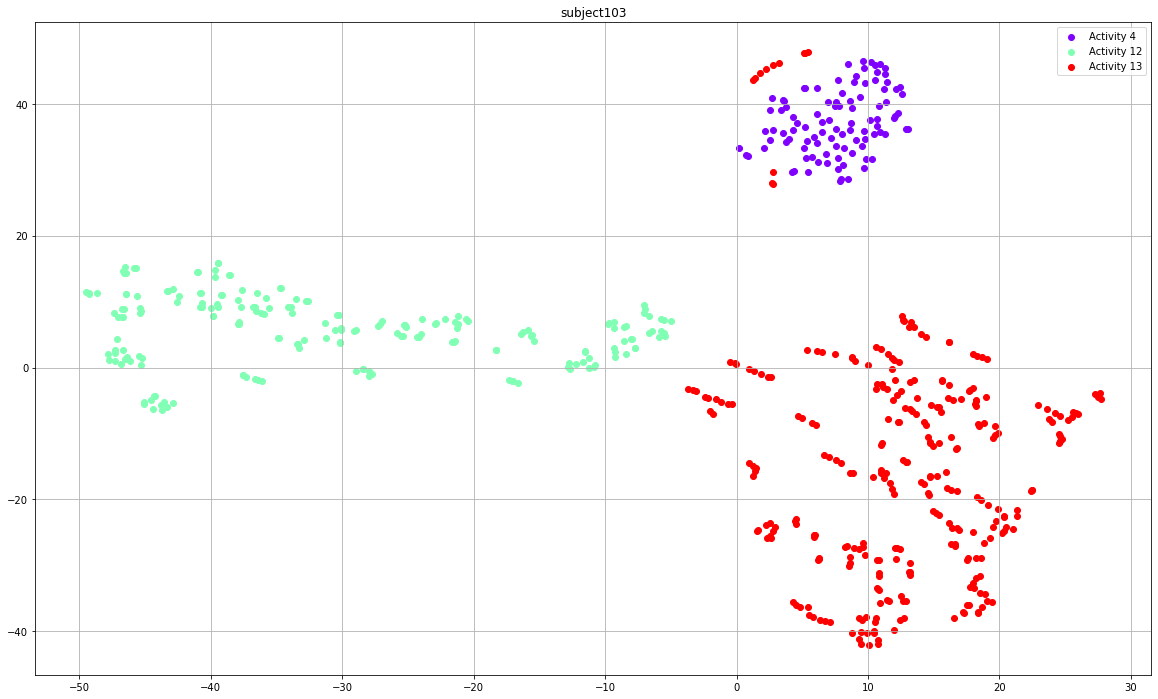

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


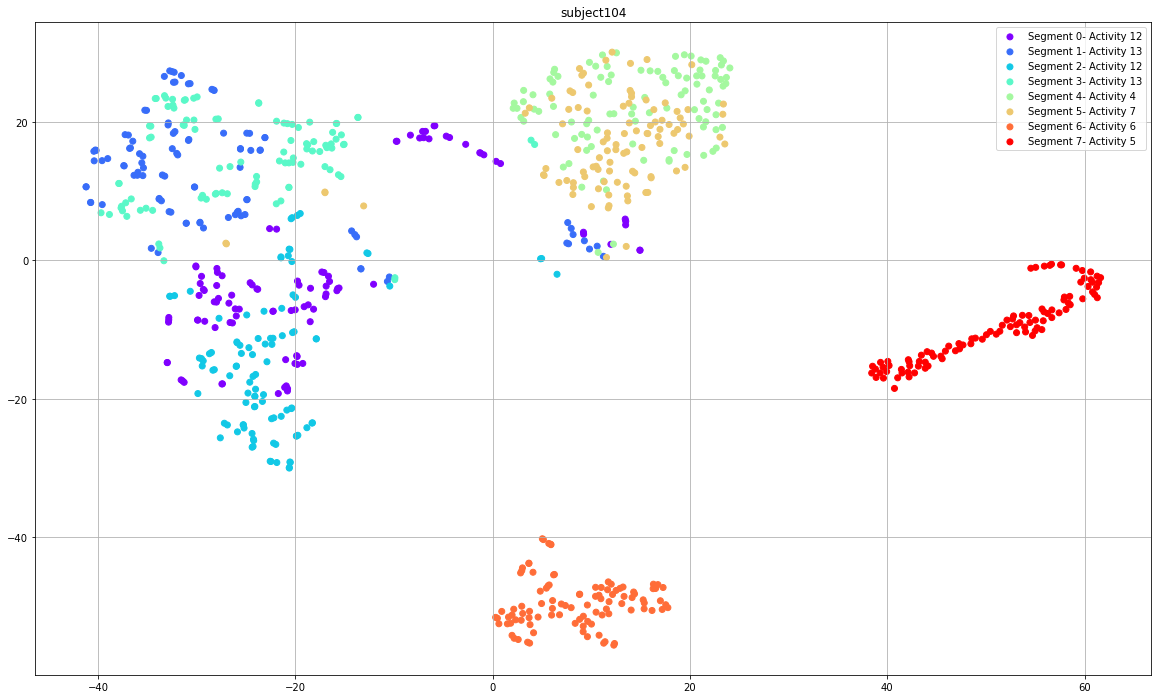

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


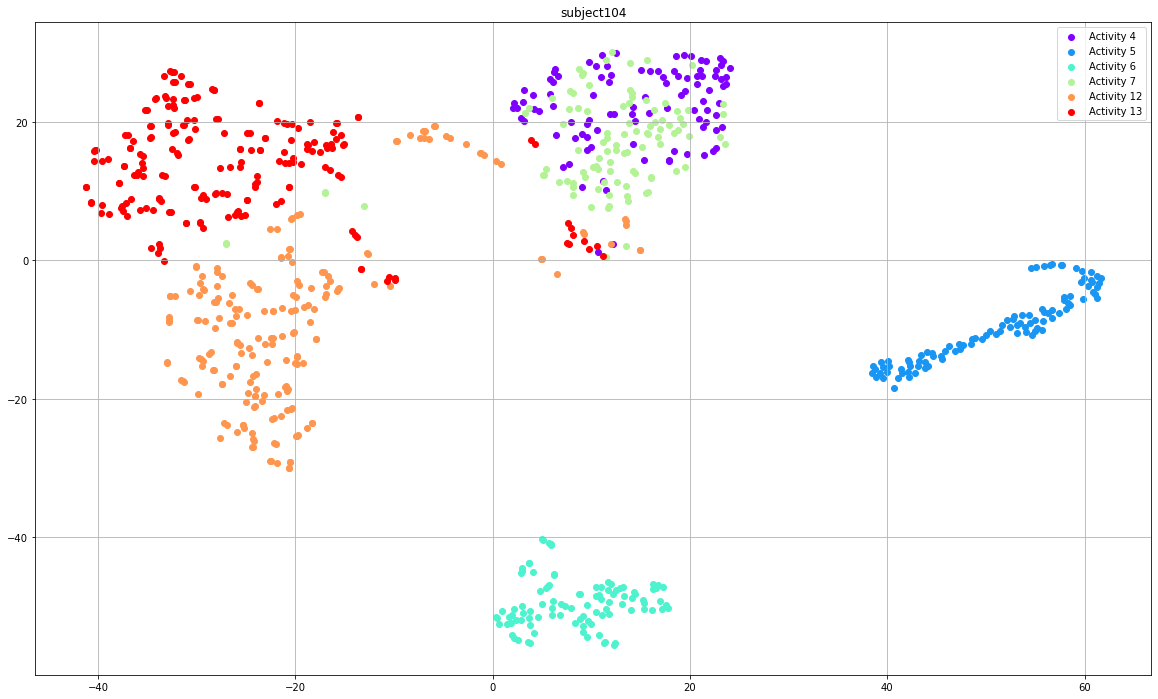

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


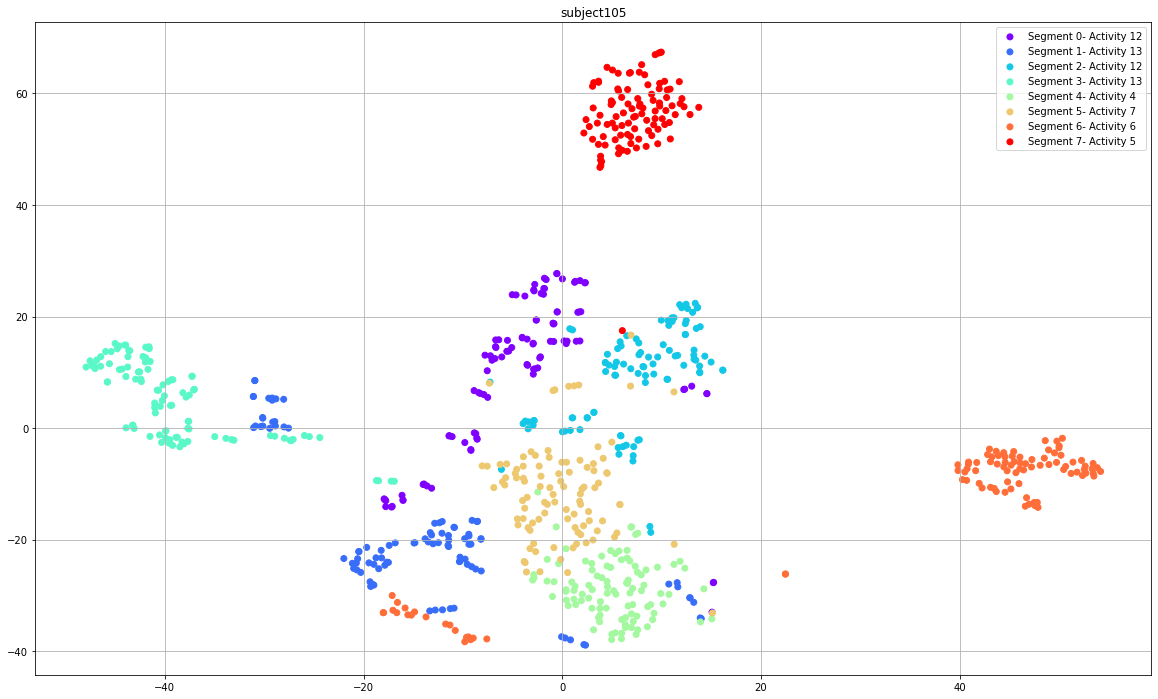

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


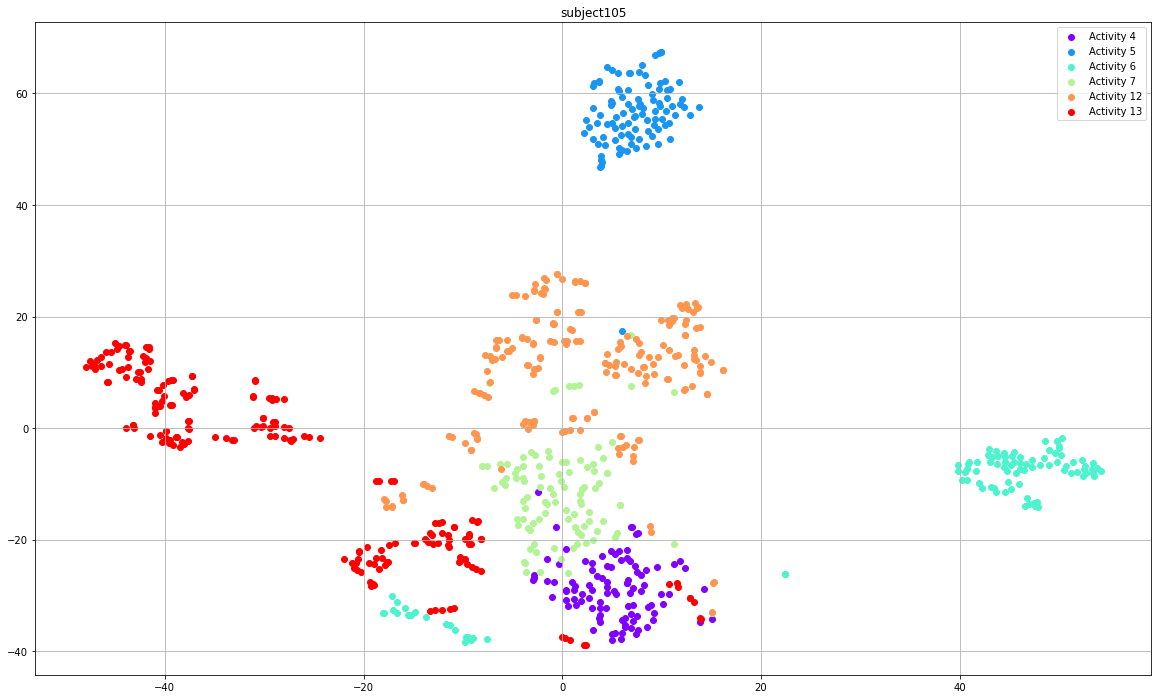

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


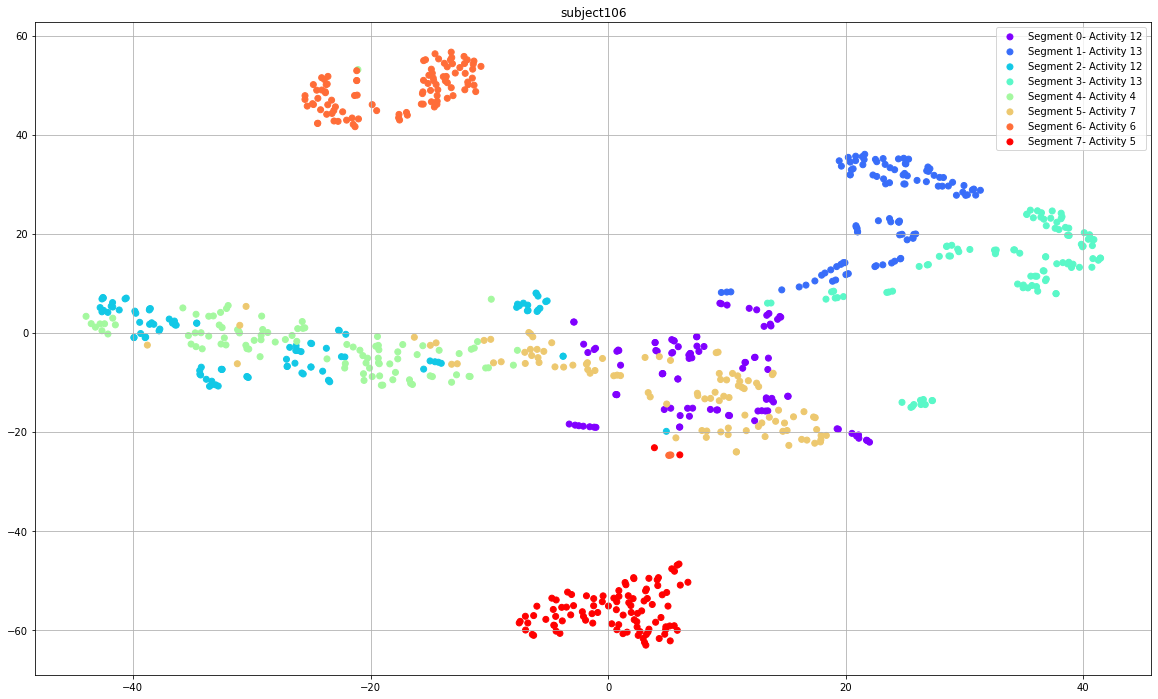

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


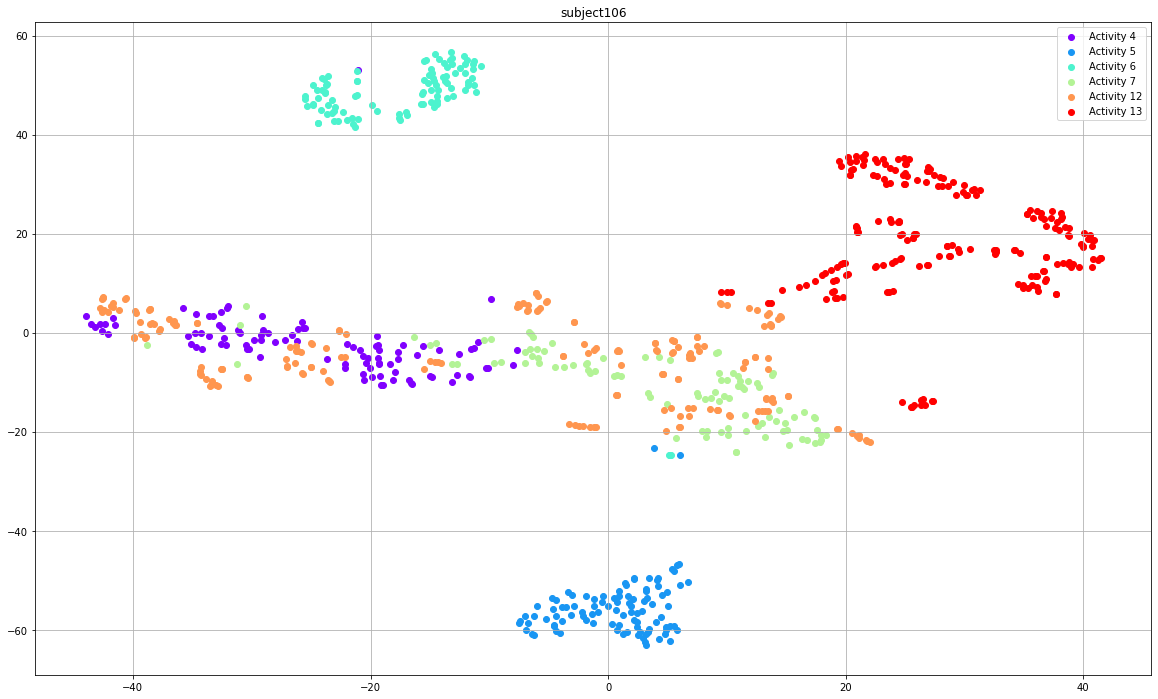

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


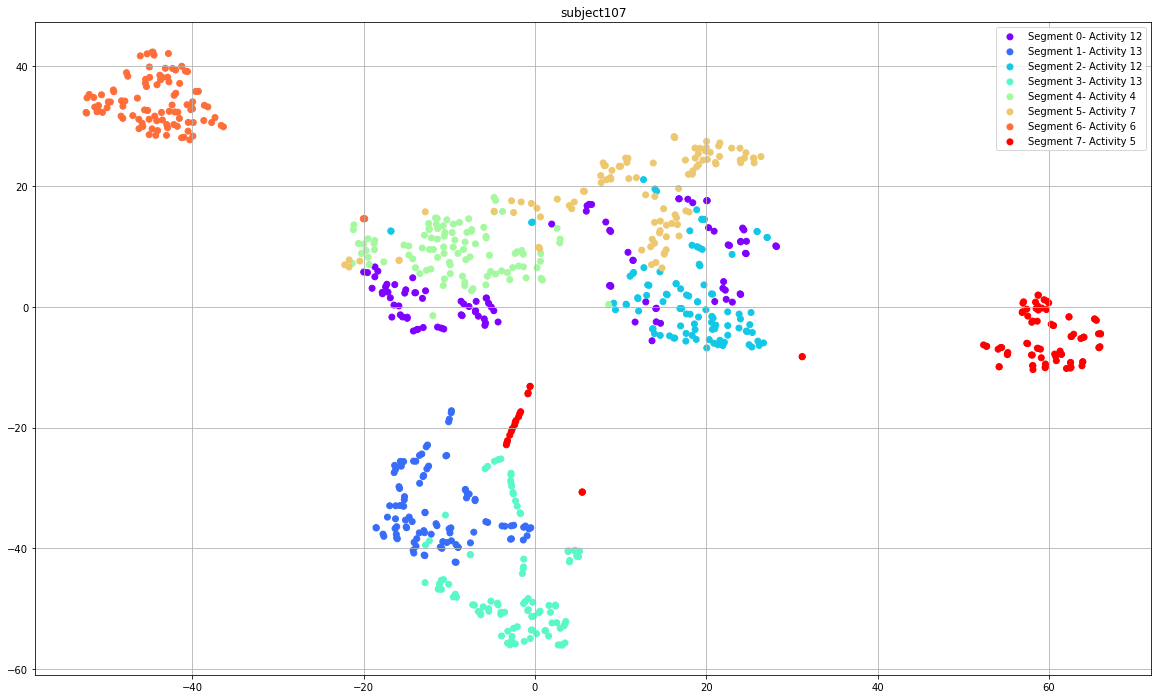

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


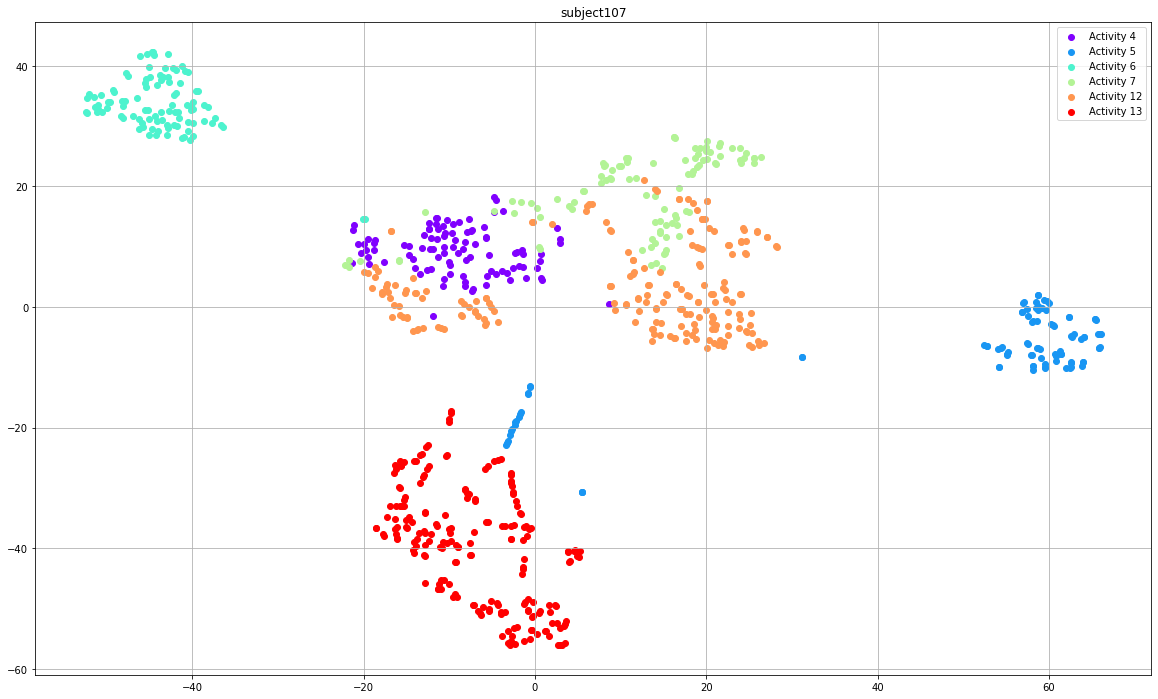

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


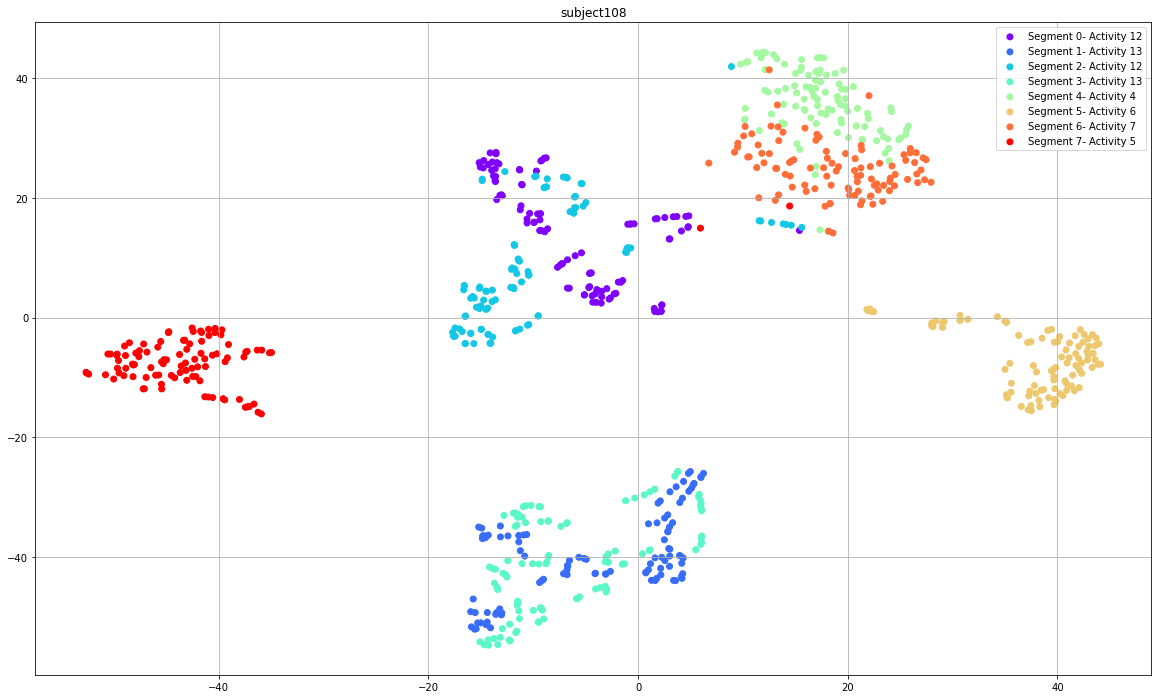

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


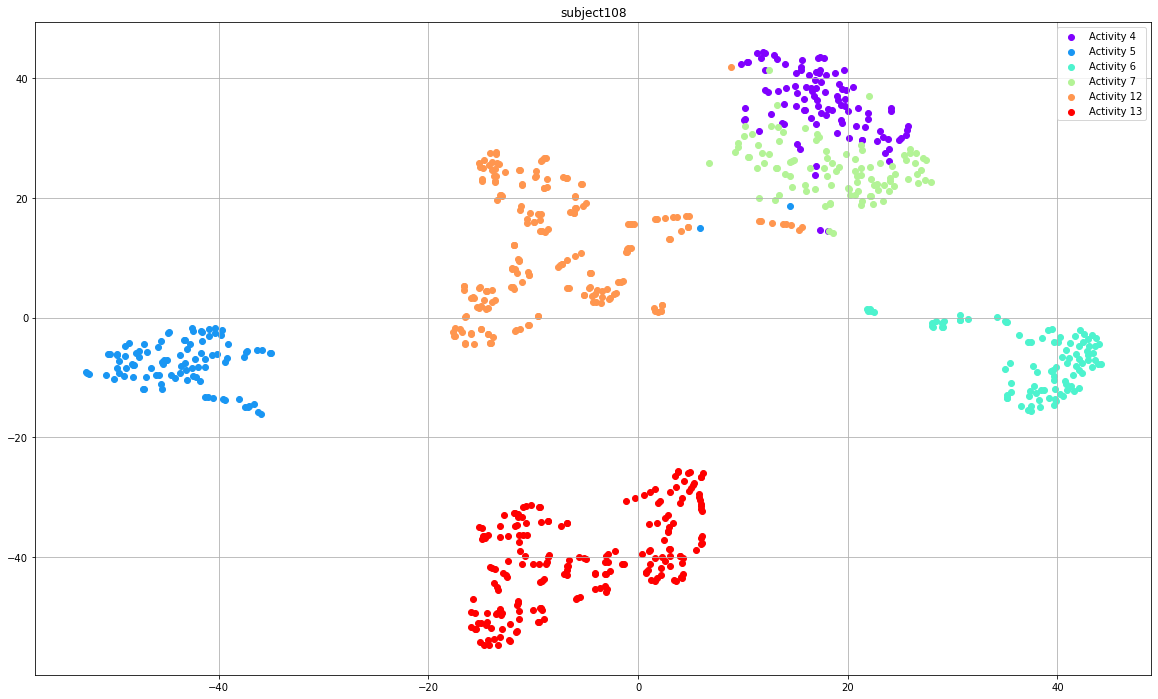

In [27]:
for subject_id_ in subject_ids:
    similarity_file_path = os.path.join(similarity_data_path, '{}-segment_similarity_matrix.csv'.format(subject_id_))
    segment_list_path = os.path.join(similarity_data_path, '{}-sampled_intervals.json'.format(subject_id_))
    plot_tsne_visualization_segments(similarity_file_path, segment_list_path, subject_id_)
    plot_tsne_visualization_activities(similarity_file_path, segment_list_path, subject_id_)